# goals
- [prepare data](#prepare)
- [outlier detection](#outlier)
- [vanilla classification](#vanilla)
- [neural network architectures](#neural)

In [1]:
# utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import librosa
# classification
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
# neural networks
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, Activation
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
'''
# process data
file = "Beatbox Sound x100/Yufu-vp-Kickdrum.wav"
    # extract individual sounds from sound file
    # feature engineering? MFCCs, ZCR
data, Fs = sf.read(file)
instance_range = range(1,len(data)//2,2)
for instance,n in zip(instance_range,len(instance_range)):
    sub_data = data[instance * Fs:(instance + 1) * Fs]
    sf.write("Yufu-vp-Kickdrum/" + n + ".wav",sub_data,Fs)
''';
### PORTED to segment.py

# prepare data

In [3]:
start_time = time.time()
root_path = "data/"
performer_paths = os.listdir(root_path)
print(performer_paths)
mfccs = []
zcrs = []
labels = []
performers = []
for performer_path in performer_paths:
    sound_paths = os.listdir(root_path + performer_path)
    for sound_path in sound_paths:
        data_path = root_path + performer_path + "/" + sound_path + "/"
        for file in os.listdir(data_path):
            data, Fs = librosa.load(data_path + "/" + file)
            if len(data.shape) == 2:
                data = data.sum(axis=1) / 2
            #get mfcc
            mfcc_temp = librosa.feature.mfcc(np.array(data),sr=Fs, n_mfcc=20, n_fft=2048, hop_length=512)
            mfccs_slice = mfcc_temp[1:13,:]
            mfccs.append(mfccs_slice.ravel())
            #get zcr
            zcr_temp = librosa.feature.zero_crossing_rate(np.array(data),frame_length=2048, hop_length=512)
            zcrs.append(zcr_temp[0])
            # meta-data
            labels.append(sound_path)
            performers.append(performer_path)
print("Processing time: {:0.2f} seconds".format(time.time() - start_time))

['yufu', 'dax']
Processing time: 113.50 seconds


In [4]:
# organize data
df_mfcc = pd.DataFrame(mfccs)
df_zcr = pd.DataFrame(zcrs)
df_mfcc['label'] = labels
df_mfcc['performer']=performers
df_zcr['label'] = labels
df_zcr['performer']=performers
X_mfcc = df_mfcc.drop(['label','performer'],axis=1)
X_zcr = df_zcr.drop(['label','performer'],axis=1)
print("MFCC shape",X_mfcc.shape)
print("ZCR shape",X_zcr.shape)

MFCC shape (699, 1044)
ZCR shape (699, 87)


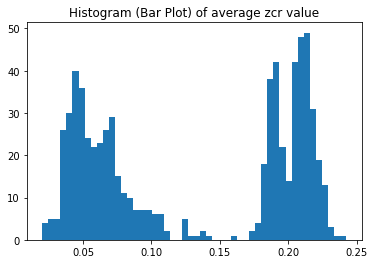

In [5]:
# histogram of mean zcr values
means = X_zcr.mean(axis=1).values
plt.hist(means, bins = 50)
plt.title("Histogram (Bar Plot) of average zcr value")
plt.show()

# clustering on zcr and mfcc

### PCA to view natural clusters

Variance explained with 2 components:  82 %


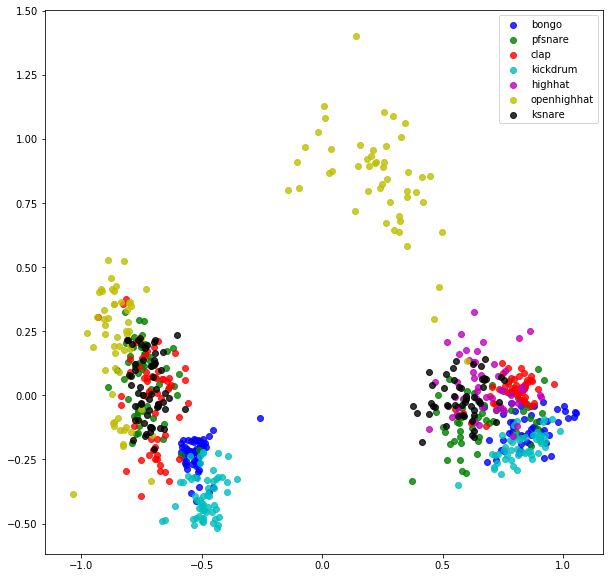

In [6]:
# pca with 2 components for visualizing outliers
pca = PCA(n_components = 2)
zcr_pca = pca.fit_transform(X_zcr)
df_zcr_pca = pd.DataFrame(zcr_pca)
df_zcr_pca['sound_profile'] = labels
print("Variance explained with 2 components: ",int(pca.explained_variance_ratio_.sum() * 100),"%")
# get colors
colors = ['b','g','r','c','m','y','k']
plt.figure(figsize=(10,10))
for n,c in zip(list(set(labels)),colors):
    sound_pca = df_zcr_pca[df_zcr_pca['sound_profile']==n]
    sns.regplot(x = sound_pca[0].values,y = sound_pca[1].values,fit_reg=False,color=c,label=n,marker='o')
plt.legend()
plt.show()

Variance explained with 2 components:  44 %


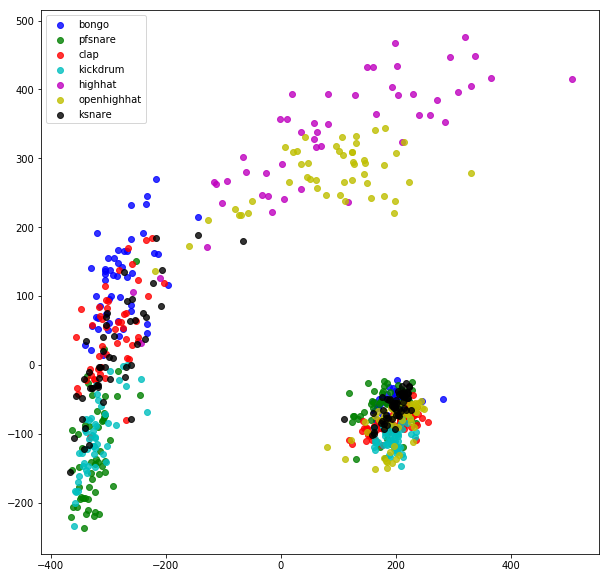

In [7]:
# pca with 2 components for visualizing outliers
pca = PCA(n_components = 2)
mfcc_pca = pca.fit_transform(X_mfcc)
df_mfcc_pca = pd.DataFrame(mfcc_pca)
df_mfcc_pca['sound_profile'] = labels
print("Variance explained with 2 components: ",int(pca.explained_variance_ratio_.sum() * 100),"%")
plt.figure(figsize=(10,10))
for label,c in zip(list(set(labels)),colors):
    sound_pca = df_mfcc_pca[df_mfcc_pca['sound_profile']==label]
    sns.regplot(x = sound_pca[0].values,y = sound_pca[1].values,fit_reg=False,color=c,label=label,marker='o')
plt.legend()
plt.show()

### unsupervised clustering 

In [8]:
km_zcr = KMeans(n_clusters=len(set(labels)))
km_zcr.fit_predict(X_zcr,labels)
labels_fact = pd.factorize(labels)
print ("ARI ",adjusted_rand_score(labels_fact[0],km_zcr.labels_))
pd.crosstab(labels_fact[0],km_zcr.labels_)

ARI  0.19185271896991296


col_0,0,1,2,3,4,5,6
row_0,,,,,,,
0,23,0,2,15,3,18,46
1,0,50,58,0,0,0,0
2,24,42,16,4,7,14,0
3,0,22,0,0,28,0,0
4,5,2,0,26,48,27,0
5,0,49,58,0,1,0,0
6,28,15,3,9,38,18,0


In [9]:
km_mfcc = KMeans(n_clusters=len(set(labels)))
km_mfcc.fit_predict(X_mfcc,labels)
print("ARI ",adjusted_rand_score(labels_fact[0],km_mfcc.labels_))
pd.crosstab(labels_fact[0],km_mfcc.labels_)

ARI  0.29416560869129815


col_0,0,1,2,3,4,5,6
row_0,,,,,,,
0,35,0,47,1,19,1,4
1,0,1,0,49,0,0,58
2,34,0,0,0,3,49,21
3,0,2,47,0,0,1,0
4,22,2,1,1,36,46,0
5,0,50,0,0,0,0,58
6,41,52,0,0,15,1,2


# Supervised classification

In [10]:
# train models: zcr
svm_zcr = SVC(C=100,kernel='linear',random_state=42)
lg_zcr = LogisticRegression(penalty='l2',C=100,tol=.0001,random_state=42,n_jobs=1)
rf_zcr = RandomForestClassifier(n_estimators=1000,max_depth=None,n_jobs=-1, random_state=42)
models_zcr = {"SVM ZCR":svm_zcr,"LG ZCR":lg_zcr,"RF ZCR":rf_zcr}
# train models: mfcc
svm_mfcc = SVC(C=1,kernel='linear',random_state=42)
lg_mfcc = LogisticRegression(penalty='l2',C=1000,tol=.0001,random_state=42,n_jobs=1)
rf_mfcc = RandomForestClassifier(n_estimators=1000,max_depth=None,n_jobs=-1, random_state=42)
models_mfcc = {"SVM MFCC":svm_mfcc,"LG MFCC":lg_mfcc,"RF MFCC":rf_mfcc}

In [11]:
# cross validation
for model in models_zcr:
    print(model)
    start_time = time.time()
    score_temp  = cross_val_score(models_zcr[model],X_zcr,labels)
    print("Accuracy: {:0.2f} +/- {:0.2f}\nTime: {:0.4f} seconds".format(score_temp.mean()*100.0,score_temp.std()*100.0,time.time()-start_time))
for model in models_mfcc:
    print(model)
    start_time = time.time()
    score_temp  = cross_val_score(models_mfcc[model],X_mfcc,labels)
    print("Accuracy: {:0.2f} +/- {:0.2f}\nTime: {:0.4f} seconds".format(score_temp.mean()*100.0,score_temp.std()*100.0,time.time()-start_time))

SVM ZCR
Accuracy: 59.35 +/- 4.64
Time: 0.1130 seconds
LG ZCR
Accuracy: 52.48 +/- 5.80
Time: 0.2709 seconds
RF ZCR
Accuracy: 70.92 +/- 6.68
Time: 6.5635 seconds
SVM MFCC
Accuracy: 95.71 +/- 2.11
Time: 0.6331 seconds
LG MFCC
Accuracy: 92.85 +/- 1.58
Time: 2.4390 seconds
RF MFCC
Accuracy: 92.27 +/- 2.09
Time: 10.9600 seconds


# neural networks

In [12]:
n_labels,n_unique = pd.factorize(labels)
nn_labels = keras.utils.to_categorical(n_labels, len(n_unique))

In [30]:
# MLP
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', input_shape=(X_mfcc.shape[1],)))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(16, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(len(n_unique), activation='softmax'))

mlp_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
start_time=time.time()
history = mlp_model.fit(X_mfcc, nn_labels,
                    batch_size=32,
                    epochs=50,
                    verbose=1,
                    validation_split=0.25)
print("Train time: {:0.2f} seconds".format(time.time()-start_time))
mlp_score = mlp_model.evaluate(X_mfcc, nn_labels, verbose=0)
print('Test loss:', mlp_score[0])
print('Test accuracy:', mlp_score[1])

Train on 524 samples, validate on 175 samples
Epoch 1/50
524/524 [==============================] - 1s 2ms/step - loss: 12.6039 - acc: 0.1336 - val_loss: 15.1171 - val_acc: 0.0000e+00
Epoch 2/50
524/524 [==============================] - 0s 131us/step - loss: 9.9765 - acc: 0.2462 - val_loss: 13.5468 - val_acc: 0.0000e+00
Epoch 3/50
524/524 [==============================] - 0s 138us/step - loss: 6.5819 - acc: 0.2958 - val_loss: 9.1026 - val_acc: 0.0000e+00
Epoch 4/50
524/524 [==============================] - 0s 150us/step - loss: 4.1426 - acc: 0.2443 - val_loss: 1.9645 - val_acc: 0.0171
Epoch 5/50
524/524 [==============================] - 0s 155us/step - loss: 2.8452 - acc: 0.2424 - val_loss: 1.9831 - val_acc: 0.0000e+00
Epoch 6/50
524/524 [==============================] - 0s 136us/step - loss: 2.1422 - acc: 0.2691 - val_loss: 1.9948 - val_acc: 0.0000e+00
Epoch 7/50
524/524 [==============================] - 0s 206us/step - loss: 1.9343 - acc: 0.2939 - val_loss: 2.0070 - val_acc: 0.

In [14]:
# CNN
img_rows, img_cols = mfccs_slice.shape
X_cnn = X_mfcc.values.reshape(X_mfcc.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Build the model
cnn_model = Sequential()
# First convolutional layer, note the specification of shape
cnn_model.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (2, 2), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.1))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(len(n_unique), activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

start_time=time.time()
cnn_model.fit(X_cnn, nn_labels,
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_split=.25)
print("Train time: {:0.2f} seconds".format(time.time()-start_time))
cnn_score = cnn_model.evaluate(X_cnn, nn_labels, verbose=0)
print('Test loss:', cnn_score[0])
print('Test accuracy:', cnn_score[1])

Train on 524 samples, validate on 175 samples
Epoch 1/5
524/524 [==============================] - 2s 4ms/step - loss: 12.1494 - acc: 0.2042 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/5
524/524 [==============================] - 2s 3ms/step - loss: 11.9757 - acc: 0.2214 - val_loss: 16.0260 - val_acc: 0.0057
Epoch 3/5
524/524 [==============================] - 2s 3ms/step - loss: 1.4712 - acc: 0.7519 - val_loss: 10.1152 - val_acc: 0.0057
Epoch 4/5
524/524 [==============================] - 2s 4ms/step - loss: 0.1103 - acc: 0.9752 - val_loss: 11.5075 - val_acc: 0.0057
Epoch 5/5
524/524 [==============================] - 2s 3ms/step - loss: 0.0400 - acc: 0.9905 - val_loss: 11.5996 - val_acc: 0.0057
Train time: 9.96 seconds
Test loss: 2.9124147446029345
Test accuracy: 0.7510729613733905


In [15]:
# RNN: LSTM
# Training parameters.
num_classes = len(n_unique)
row_hidden = 32
col_hidden = 32
row, col, pixel = X_cnn.shape[1:]


x = Input(shape=(row, col, pixel))
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)
encoded_columns = LSTM(col_hidden)(encoded_rows)
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
lstm_model = Model(x, prediction)
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Evaluate model
start_time=time.time()
lstm_model.fit(X_cnn, nn_labels,
          batch_size=16,
          epochs=30,
          verbose=1,
          validation_split=0.25)
print("Train time: {:0.2f} seconds".format(time.time()-start_time))
lstm_score = lstm_model.evaluate(X_cnn, nn_labels, verbose=0)
print('Test loss:', lstm_score[0])
print('Test accuracy:', lstm_score[1])

Train on 524 samples, validate on 175 samples
Epoch 1/30
524/524 [==============================] - 3s 6ms/step - loss: 1.8754 - acc: 0.2042 - val_loss: 2.2341 - val_acc: 0.0057
Epoch 2/30
524/524 [==============================] - 2s 4ms/step - loss: 1.7305 - acc: 0.2481 - val_loss: 2.7962 - val_acc: 0.0057
Epoch 3/30
524/524 [==============================] - 3s 5ms/step - loss: 1.5821 - acc: 0.3034 - val_loss: 3.1687 - val_acc: 0.0000e+00
Epoch 4/30
524/524 [==============================] - 2s 4ms/step - loss: 1.4309 - acc: 0.3969 - val_loss: 3.3135 - val_acc: 0.0286
Epoch 5/30
524/524 [==============================] - 2s 5ms/step - loss: 1.3046 - acc: 0.4389 - val_loss: 3.8100 - val_acc: 0.0171
Epoch 6/30
524/524 [==============================] - 2s 5ms/step - loss: 1.1855 - acc: 0.5286 - val_loss: 3.6396 - val_acc: 0.0571
Epoch 7/30
524/524 [==============================] - 2s 4ms/step - loss: 1.0774 - acc: 0.5916 - val_loss: 4.3152 - val_acc: 0.0114
Epoch 8/30
524/524 [======

In [16]:
# AE